# Refining Model Accuracies
The goal of this project is to create a workflow for cyclic exploration, engineering and selection of features and models - the frame is that of a Kaggle contest, where results are iteratively checked and improved on.

The Kaggle contest is a classic one for data science beginners: the goal is to predict whether a test set of passengers embarked on the Titanic survived the sinking of the ship or perished in the [accident](https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic).

## Data acquisition and processing

In [37]:
import pandas as pd
train = pd.read_csv("train.csv")
holdout = test = pd.read_csv("test.csv")

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

pivot_table() is an excellent tool for exploring how certain variables relate to the target (particularly when the target is a binary category). The first task will be looking at sex, age and class of the passengers.

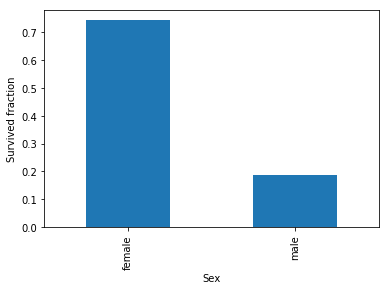

In [39]:
# Let's start with examining the sex of the passengers
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar(legend=False)
plt.ylabel("Survived fraction")
plt.show()

It is clear that women survived the sinking in vastly larger numbers: limitedly to the training dataset, slightly less than 2 out of 10 men survived, while more than 7 out of 10 women survived the ordeal. A specific "sex_female" categorical feature would have a large impact on predicting the final fate of the passengers.

Next up, the 'Age' column.

In [40]:
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [41]:
train["Age"].isnull().sum()

177

It appears that the Age column contains a fair number of missing data. This must be dealt with somehow. 

Furthermore, one should think about what an 'Age' feature represents. Although numeric in nature, the age of a person has a significance that is looser than that of e.g. a temperature. Therefore one could consider cutting this continuous variable into a set number of categories. The pandas.cut() method is a convenient tool for cutting continuous variables into labeled bins.

In [50]:
def categorical_cut(df,target,new_name,cut_points,label_names):
    df[new_name] = pd.cut(df[target],cut_points,labels=label_names)
    return df

In [51]:
# Missing values are filled with a -0.5: pandas.cut() can easily categorize these as "Missing" 
train["Age"] = train["Age"].fillna(-.5)
holdout["Age"] = holdout["Age"].fillna(-.5)

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
train = categorical_cut(train,"Age","Age_categories",cut_points,label_names)
holdout = categorical_cut(holdout,"Age","Age_categories",cut_points,label_names)

In [64]:
age_pivot = train.pivot_table(index="Age_categories",values="Survived")
#### NOTE: pivot_table for some reason provides a bugged output - the Age_categories index appears in order of appearance 
#### within the train dataframe and not in correct correspondence with its Survived fraction:
print(train[["Age","Age_categories"]].head(10))
print(age_pivot)

    Age Age_categories
0  22.0    Young Adult
1  38.0          Adult
2  26.0    Young Adult
3  35.0    Young Adult
4  35.0    Young Adult
5  -0.5        Missing
6  54.0          Adult
7   2.0         Infant
8  27.0    Young Adult
9  14.0       Teenager
                Survived
Age_categories          
Young Adult     0.293785
Adult           0.704545
Missing         0.360000
Infant          0.428571
Teenager        0.382682
Child           0.400000
Senior          0.227273


In [57]:
#### The correct output is the following instead:
YA = train.loc[train["Age_categories"]=="Young Adult","Survived"].sum()/train.loc[train["Age_categories"]=="Young Adult","Survived"].shape[0]
A = train.loc[train["Age_categories"]=="Adult","Survived"].sum()/train.loc[train["Age_categories"]=="Adult","Survived"].shape[0]
M = train.loc[train["Age_categories"]=="Missing","Survived"].sum()/train.loc[train["Age_categories"]=="Missing","Survived"].shape[0]
I = train.loc[train["Age_categories"]=="Infant","Survived"].sum()/train.loc[train["Age_categories"]=="Infant","Survived"].shape[0]
T = train.loc[train["Age_categories"]=="Teenager","Survived"].sum()/train.loc[train["Age_categories"]=="Teenager","Survived"].shape[0]
C = train.loc[train["Age_categories"]=="Child","Survived"].sum()/train.loc[train["Age_categories"]=="Child","Survived"].shape[0]
S = train.loc[train["Age_categories"]=="Senior","Survived"].sum()/train.loc[train["Age_categories"]=="Senior","Survived"].shape[0]
print("Young Adult: ",YA,"\nAdult: ",A,"\nMissing: ",M,"\nInfant: ",I,"\nTeenager: ",T,"\nChild: ",C,"\nSenior: ",S)

Young Adult:  0.38268156424581007 
Adult:  0.4 
Missing:  0.2937853107344633 
Infant:  0.7045454545454546 
Teenager:  0.42857142857142855 
Child:  0.36 
Senior:  0.22727272727272727


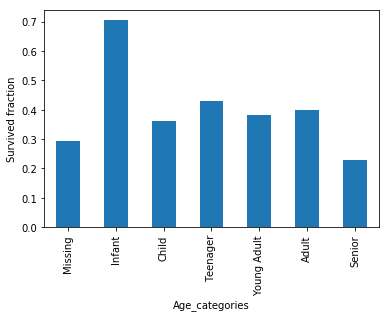

In [63]:
# Manually relabel the y-axis ticks to circumvent the issue
fig, ax = plt.subplots()
age_pivot.plot.bar(legend=False,ax=ax)
ax.set_ylabel("Survived fraction")
ax.set_xticklabels(label_names)
plt.show()

Infants survived the sinking of the RMS Titanmic in disproportionate amount compared to other age categories. A specific "age_infant" categorical feature would have a large impact on predicting the final fate of the passengers.

Finally, the ticket class of each passenger will be examined.

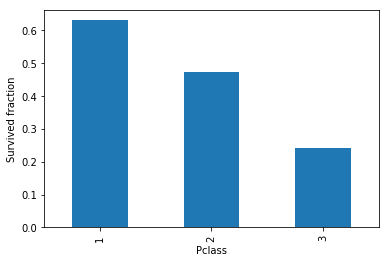

In [65]:
class_pivot = train.pivot_table(index="Pclass",values="Survived")
class_pivot.plot.bar(legend=False)
plt.ylabel("Survived fraction")
plt.show()

The survival rate of the passengers in First Class is much higher than that of other classes, particularly compared to Third Class. A specific "first_class" categorical feature would have a large impact on predicting the final fate of the passengers.

Categorical features cannot be handled by classifier models straight out of the box: models in general use numerical variables, and categorical features have no numerical value *sensu stricto*. To circumvent this, dummy columns are used.

Dummy columns expand categorical variables and let models handle them without the fictitious numerical relationships that their numbering entails (i.e. category 2 isn't "double" category 1 nor 3 is "triple" category 1 - they're related, but not in a strict numerical sense).

In [66]:
def create_dummies(df,columns):
    for c in columns:
        dummies = pd.get_dummies(df[c],prefix=c)
        df = pd.concat([df,dummies],axis=1)
    return df

In [67]:
columns = ["Pclass","Sex","Age_categories"]
train = create_dummies(train,columns)
holdout = create_dummies(holdout,columns)

In [68]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior'],
      dtype='object')


A quick test can be made to check the performance of a Logistic Regression trained on the new dummy columns.

In [69]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior']

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # This lets us conveniently split our training data into train and test
                                                     # subsets to avoid overfitting our model.

In [71]:
all_X = train[columns]
all_y = train["Survived"]
train_X, test_X, train_y, test_y = train_test_split(all_X,all_y,test_size=.2,random_state=0)

The sklearn.metrics.accuracy_score() method can now be used to calculate the accuracy score of the predictions. This is literally just the fraction of predictions the model managed to guess correctly.

In [72]:
from sklearn.metrics import accuracy_score

In [73]:
lr = LogisticRegression()
lr.fit(train_X,train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y,predictions)
print("AUC: ",accuracy)

AUC:  0.8100558659217877


An even better way of testing the accuracy of our model is to execute cross-validation of the predictions: the data is split into multiple folds, with each one being used exactly once as the test set. With this method all of the training data can be used and a more reliable accuracy value can be given as the mean of all accuracies.

In [74]:
from sklearn.model_selection import cross_val_score
import numpy as np

In [75]:
lr = LogisticRegression()
scores = cross_val_score(lr,all_X,all_y,cv=10)
accuracy = np.mean(scores)
print("AUC: ",accuracy)

AUC:  0.8024670865963002


In [76]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

submission = pd.DataFrame({
    "PassengerId": holdout["PassengerId"],
    "Survived": holdout_predictions
})
submission.to_csv("submission.csv",index=False)

Now the predictions can be submitted to Kaggle. The real accuracy this model managed to get on the holdout dataset turns out to be *75.6%*. Can this be improved?

## Feature engineering
The available features should be examined again and checked for feature engineering opportunities.

In [78]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior'],
      dtype='object')


There's a number of columns that haven't been examined yet. These are 'SibSp', 'Parch', 'Fare', 'Cabin' and 'Embarked'.

In [79]:
columns = ['SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
train[columns].describe(include="all")

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,G6,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,7.910400,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,0.000000,31.000000,NaN,NaN


In [80]:
train[columns].isnull().sum()

SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

A chunk of passenger entries in the training dataset have null values for the 'Cabin' variable, and two of them have null values for 'Embarked' too.

In [81]:
holdout[columns].describe(include="all")

,SibSp,Parch,Fare,Cabin,Embarked
count,418.000000,418.000000,417.000000,91,418
unique,NaN,NaN,NaN,76,3
top,NaN,NaN,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,NaN,3,270
mean,0.447368,0.392344,35.627188,NaN,NaN
std,0.896760,0.981429,55.907576,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,7.895800,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,0.000000,31.500000,NaN,NaN


In [82]:
holdout[columns].isnull().sum()

SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64

The holdout dataset also has a chunk of passenger entries with null 'Cabin' values, plus a single null value for the 'Fare' variable.

For now, the 'Embarked' and 'Fare' missing values can be filled in using their mode and mean respectively (since one is categorical and the other numerical and continuous). The Cabin column will be dealt with further down the road.

In [83]:
train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")
holdout["Fare"] = holdout["Fare"].fillna(holdout["Fare"].mean())

In [84]:
train = create_dummies(train,["Embarked"])
holdout = create_dummies(holdout,["Embarked"])

An important step to remember is the rescaling of numerical variables. The sklearn.preprocessing.minmax_scale() method rescales numerical variables so that they are all distributed within the same range, eliminating any bias that would waylay the model.

In [85]:
from sklearn.preprocessing import minmax_scale

In [86]:
columns = ["SibSp_scaled","Parch_scaled","Fare_scaled"]
target_columns = ["SibSp","Parch","Fare"]

for i in range(3):
    train[columns[i]] = minmax_scale(train[target_columns[i]])
    holdout[columns[i]] = minmax_scale(holdout[target_columns[i]])

C:\Users\jacop\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [89]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled'],
      dtype='object')


Now all previous columns plus the new rescaled ones can be selected as features.

In [90]:
columns = ['Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled',
       'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [91]:
all_X = train[columns]
all_y = train["Survived"]

Instead of using all these features together, one should try to find ways to identify just the best among them. Looking at the absolute values of the regression coefficients is a great way to select the best features for our model.

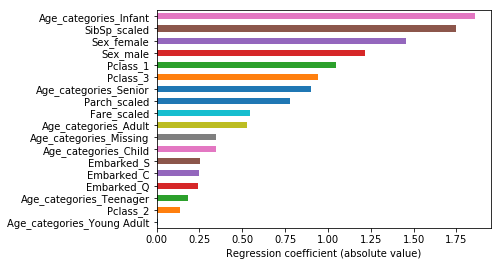

In [93]:
lr = LogisticRegression()
lr.fit(all_X,all_y)

coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0],
                               index=all_X.columns)
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.xlabel("Regression coefficient (absolute value)")
plt.show()

In [94]:
# Select the columns with absolute regression coefficients above .75
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
all_X = train[columns]
all_y = train["Survived"]

In [95]:
lr = LogisticRegression()
scores = cross_val_score(lr,train[columns],train["Survived"],cv=10)
accuracy = np.mean(scores)
print("AUC: ",accuracy)

AUC:  0.8148019521053229


In [96]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

submission = pd.DataFrame({
    "PassengerId": holdout["PassengerId"],
    "Survived": holdout_predictions
})
submission.to_csv("submission.csv",index=False)

Once the new predictions are submitted to Kaggle, the real accuracy obtained by this latest model on the holdout dataset is found as *77.0%*. Can this be improved even further?

The next step involves a different approach to the 'Fare' variable: as was the case for the 'Age' variable, 'Fare' may be converted into a categorical variable by cutting it at set value points. 

In [97]:
cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = categorical_cut(train,"Fare","Fare_categories",cut_points,label_names)
holdout = categorical_cut(holdout,"Fare","Fare_categories",cut_points,label_names)

train = create_dummies(train,["Fare_categories"])
holdout = create_dummies(holdout,["Fare_categories"])

Secondly, the 'Name' column can be engineered too. Individually the names are unique and thus have no predictive quality. However, many names share a title like Mr. or Mrs., which can be extracted using a dictionary and grouped up as categories.

In [98]:
train["Name"].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [99]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

In [100]:
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False) # Filter only alphabetic symbols and whitespace
train["Title"] = extracted_titles.map(titles)
train = train.drop("Name",axis=1)
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False) # Filter only alphabetic symbols and whitespace
holdout["Title"] = extracted_titles.map(titles)
holdout = holdout.drop("Name",axis=1)

Finally, the 'Cabin' variable.

In [101]:
train["Cabin"].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

As seen before, many of these values are null. These likely correspond to third class tickets with no assigned cabin, and may be set as "Unknown". As for the valid cabin IDs, the number is of little use, but the letter identified specific areas of the ship and therefore contains precious information.

In [102]:
train["Cabin_type"] = train["Cabin"].str[0] # Extract the first letter of the cabin ID
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")
train = train.drop("Cabin",axis=1)
holdout["Cabin_type"] = holdout["Cabin"].str[0] # Extract the first letter of the cabin ID
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")
holdout = holdout.drop("Cabin",axis=1)

In [103]:
train = create_dummies(train,["Title","Cabin_type"])
holdout = create_dummies(holdout,["Title","Cabin_type"])

In [104]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Age_categories', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'SibSp_scaled', 'Parch_scaled',
       'Fare_scaled', 'Fare_categories', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title', 'Cabin_type', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T',
       'Cabin_type_Unknown'],
      dtype='object')


There are many features now, and there's the real risk that some of them may be positively correlated and thus redundant - i.e. columns such as 'Title_Mr' and 'Title_Mrs' can be expected to closely resemble the distirbution of the 'Sex_male' and 'Sex_female' columns. A list of column candidates for elimination can thus be constructed by calculating correlation coefficients between features and by using a heatmap to catch at a glance all redundant columns.

In [105]:
import seaborn as sns

Heatmaps let us understand the relationship between features. As stated, the goal is to avoid features which are redundant, i.e. that are highly correlated between them and are thus likely to convey the same kind of information.

In [106]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

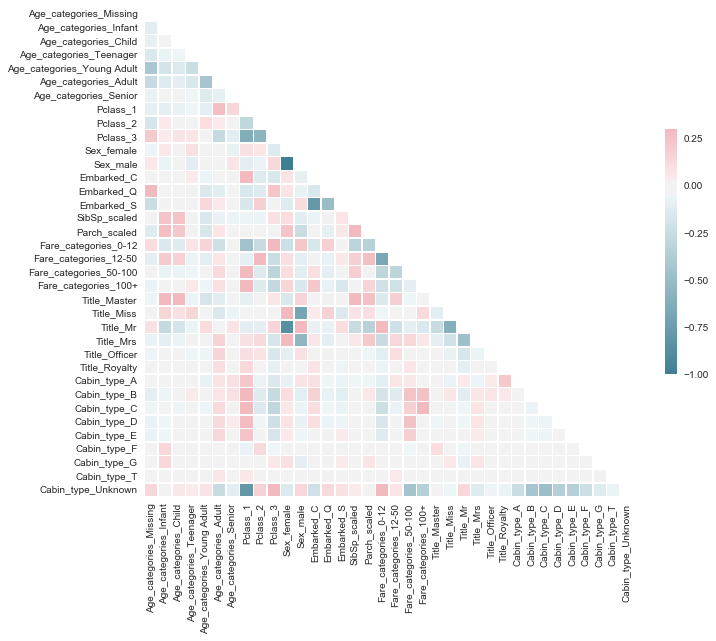

In [107]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

None of the features have extremely strong positive correlations, so it is hard to determine which ones to remove with certainty. Sex_male and Sex_female are very similar to the Title columns though, and the latter ones are more nuanced. The choice is made here to drop the Sex_male and Sex_female columns. Also note the extremely strong negative correlation on some of the features: these of course indicate mutually exclusive variables.

Furthermore, it is good practice to eliminate one among the features for each of the sets of categorical dummy columns to prevent some internal correlation between dummy columns.

In [108]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

Another very useful tool from sklearn is sklearn.feature_selection.RFECV(). This function cross references and evaluates the features and selects those that are best for predicting the target variable.

In [109]:
from sklearn.feature_selection import RFECV

In [110]:
lr = LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X,all_y)
optimized_columns = all_X.columns[selector.support_]
print(optimized_columns)

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')


Title_Mr correlates well with Sex_male, so this variable characterizes the sex. Cabin_type_Unknown correlates well with Pclass_3, so this variable characterizes whether the passenger was in third or not. Title_Officer is curious - perhaps Officers predominantly survived or perished. SibSp_scaled is another curious one: apparently the number of siblings and/or spouses on board had a non-random impact on the survivability of the passengers.

In [111]:
all_X = train[optimized_columns]
lr = LogisticRegression()
scores = cross_val_score(lr,all_X,all_y,cv=10)
accuracy = np.mean(scores)
print("AUC: ",accuracy)

AUC:  0.8226549199863807


In [113]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

submission = pd.DataFrame({
    "PassengerId": holdout["PassengerId"],
    "Survived": holdout_predictions
})
submission.to_csv("submission.csv",index=False)

Once the new predictions are submitted to Kaggle, the real accuracy obtained by this latest model on the holdout dataset increases to *78.5%*. The features have now been engineered extensively - what can be done about model selection?

## Model selection
#### K-Neighbors Classifier
The first alternative model to be tested will be a K-Neighbors Classifier. For the first attempt, k = 1.

In [116]:
from sklearn.neighbors import KNeighborsClassifier

In [117]:
knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(knn,all_X,all_y,cv=10)
accuracy_knn = np.mean(scores)
print("AUC: ",accuracy_knn)

AUC:  0.7429142549086369


The accuracy fell by quite a lot - a K-Neighbors Classifier may not be the most powerful of models, but then again setting k = 1 may also be a suboptimal choice. For the second attempt, k will be set to increasing values and the accuracy will be tested each time. This is known as hyperparameter optimization: the hyperparameters are the parameters which describe and tune the model.

In [118]:
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),ylim=(0.68,0.83),rot=0)
    plt.ylabel("Accuracy")
    plt.xlabel("k Value")
    plt.show()

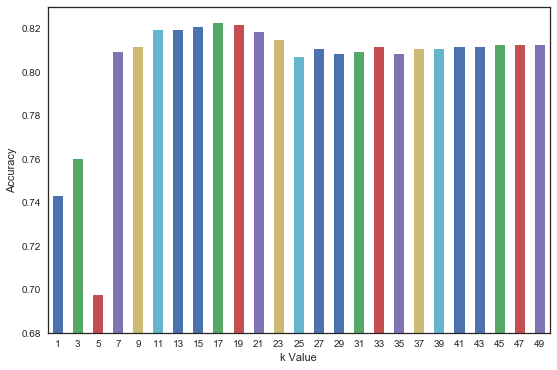

In [121]:
knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,all_X,all_y,cv=10)
    knn_scores[k] = np.mean(scores)
plot_dict(knn_scores)

In [122]:
print("AUC: ",knn_scores[17])

AUC:  0.8226674043808876


A good result. Hyperparameter optimization is an important part of the model refining process - however it can also become increasingly tricky as more and more parameters are added over which the model can change. Helpfully, sklearn has a dedicated tool for hyperparameter optimization i.e. the sklearn.model_selection.GridSearchCV() method. 

When a dictionary of possible hyperparameter ranges is passed to the method, GridSearchCV() cycles over all hyperparameter combinations and finds the best possible model within the assigned boundaries. The best hyperparameters and the corresponding accuracy score are then easily accessible.

In [123]:
from sklearn.model_selection import GridSearchCV

In [124]:
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute','auto'],
    "p": [1,2]
}

In [127]:
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X,all_y)
best_params = grid.best_params_
best_score = grid.best_score_
print("Best Parameters: ",best_params,"\nBest Score: ",best_score)

Best Parameters:  {'algorithm': 'auto', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'} 
Best Score:  0.8226711560044894


In [128]:
best_knn = grid.best_estimator_
holdout_predictions = best_knn.predict(holdout[optimized_columns])

submission = pd.DataFrame({
    "PassengerId": holdout["PassengerId"],
    "Survived": holdout_predictions
})
submission.to_csv("submission.csv",index=False)

Once the new predictions are submitted to Kaggle, the real accuracy obtained by the latest model falls down to *77%* again. K-Neighbors Classifiers don't seem to fare so well.

#### Random Forest Classifier
The last model to be tested will be an ensemble Decision Tree model, i.e. a Random Forest Classifier.

In [130]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
rf = RandomForestClassifier(random_state=1)
scores = cross_val_score(rf,all_X,all_y,cv=10)
accuracy_rf = np.mean(scores)
#print("AUC: ",accuracy_rf)
print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


In [132]:
hyperparameters = {
    "criterion": ["entropy","gini"],
    "max_depth": range(1,20,2),
    "max_features": ["log2","sqrt","auto"],
    "min_samples_leaf": [1,5],
    "min_samples_split": [3,5],
    "n_estimators": [6,9]
}

In [133]:
rf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(rf, param_grid=hyperparameters, cv = 10)
grid.fit(all_X,all_y)
best_params = grid.best_params_
best_score = grid.best_score_
print("Best Parameters: ",best_params,"\nScore: ",best_score)

Best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 6} 
 Score:  0.8226711560044894


In [134]:
best_rf = grid.best_estimator_
holdout_predictions = best_rf.predict(holdout[optimized_columns])

predictions = best_rf.predict(holdout[optimized_columns])
submission = pd.DataFrame({
    "PassengerId": holdout["PassengerId"],
    "Survived": predictions
})
submission.to_csv("submission.csv",index=False)

Once the new predictions are submitted to Kaggle, the real accuracy obtained by the latest model rises up to *78.5%* again. This value can't seem to be surpassed for the moment being. Strategies to try in this quest towards an higher score are:
- Further feature engineering. New features may be created by manipulating existing ones in clever ways. Going back to the starting problem and reading and learning about the original scenario which produced the data is often important to find new ways in which to interpret and describe the data.
- Employment of more powerful techniques such as support vector machines, stochastic gradient descent or perceptron linear models. All of these have bespoke sklearn methods and can be optimized using GridSearchCV.